<a href="https://colab.research.google.com/github/solislemuslab/dna-nn-theory/blob/master/scripts/splice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q biopython

     |████████████████████████████████| 2.3MB 2.7MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/My Drive/dna_nn' .
!ls dna_nn

download.py  load.py


In [ ]:
import gc

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from dna_nn.load import encode, encoded_shape, gen_from_arrays

%load_ext autoreload
%autoreload 2

In [ ]:
d = {'EI': 0, 'IE': 1, 'N': 2}

DATA_PATH = '/content/drive/My Drive/data/UCI/splice.data'

data = pd.read_csv(DATA_PATH, header=None, sep=',\\W*', engine='python',
                   usecols=[0, 2])
data.columns = ['class', 'sequence']
for old, new in zip('NDSR', 'ATCG'):
    data['sequence'] = data['sequence'].str.replace(old, new)
data['class'] = data['class'].map(lambda y: d[y])
data.head()

,class,sequence
0,0,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,0,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,0,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,0,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,0,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...


# features: 60 bp


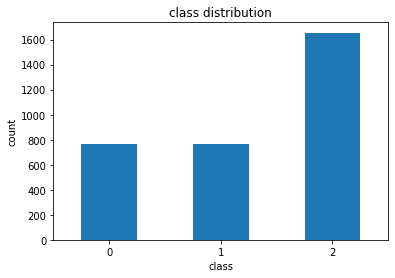

In [ ]:
ax = data['class'].value_counts().sort_index().plot(kind='bar')
ax.set_title('class distribution')
ax.set_xlabel('class')
ax.set_ylabel('count')
ax.tick_params(rotation=0)

print('# features:', len(data['sequence'][0]), 'bp')

# Conv2d

In [ ]:
word_size = 3
region_size = 0

encode_func = encode(word_size, region_size)
x_shape = encoded_shape(data['sequence'][0], word_size, region_size)

x, y = data['sequence'].to_numpy(), data['class'].to_numpy()
x = np.array([encode_func(_) for _ in x])
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

len(x_train), len(x_test)

(2392, 798)

In [ ]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(64, 3, activation='relu', input_shape=x_shape),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 62, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 55552)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55552)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               7110784   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [ ]:
# 10 seconds per epoch
history = model.fit(x_train, y_train, epochs=15, validation_split=0.15, verbose=0)

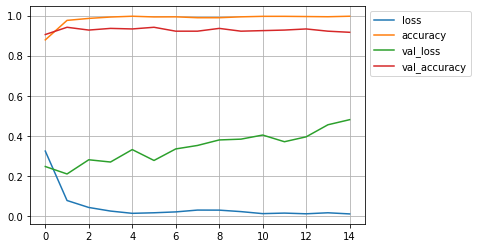

In [ ]:
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [ ]:
model.evaluate(x_test, y_test, verbose=2)

25/25 - 1s - loss: 0.3172 - accuracy: 0.9386


[0.3171690106391907, 0.9385964870452881]

In [ ]:
model.save('/content/drive/My Drive/dna-nn/UCI/splice-2D.h5')

# Conv1D

In [ ]:
encode_func = encode(word_size, region_size, expand=False)
x_shape = encoded_shape(data['sequence'][0], word_size, region_size, expand=False)

x, y = data['sequence'].to_numpy(), data['class'].to_numpy()
x = np.array([encode_func(_) for _ in x])
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

len(x_train), len(x_test)

(2392, 798)

In [ ]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv1D(64, 3, activation='relu', input_shape=x_shape),
    keras.layers.MaxPooling1D(),
    keras.layers.Dropout(0.75),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.75),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 56, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 28, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               229504    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [ ]:
# 1 second per epoch
history = model.fit(x_train, y_train, epochs=30, validation_split=0.15, verbose=0)

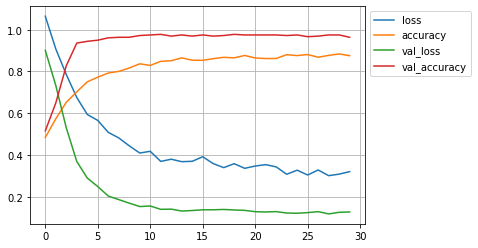

In [ ]:
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [ ]:
model.evaluate(x_test, y_test, verbose=2)

25/25 - 0s - loss: 0.1312 - accuracy: 0.9687


[0.13117338716983795, 0.9686716794967651]

In [ ]:
model.save('/content/drive/My Drive/dna-nn/UCI/splice-1D.h5')